In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
import sys
sys.path.insert(0,"..")
from predict.prediction_batch import greedy_decode_batch
from predict.prediction_string import decode_seq_str, decode_interacively
import pdb
from model.loss import LossCompute
import os
from io_.info_print import printing
from model.seq2seq import LexNormalizer
from model.generator import Generator
from evaluate.interact import interact
MAX_LEN = 20
script_dir = "."

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#model_folder_starts_with = "f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04"
#model_folder_starts_with = "f178-DROPOUT_EVEN_INCREASE-0.1-to_sent+word+bridge_out-model_3_046c"
#model_folder_starts_with = "8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout0.1_scale_aux-True_aux-0.1do_char_dec-True_char_src_atten-model_14_ad6c"
#model_folder_starts_with = "a5c77"
#model_folder_starts_with = "fef8-new_data-batchXdropout_char0-to_char_src-1_dir_sent-10_batch_size-model_2_51a5"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3"
#model_folder_starts_with ="8ce6b"
#model_folder_starts_with = "8e628"
#model_folder_starts_with = "84736"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-True_char_src_atten-model_10_b59b"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-False_char_src_atten-model_9_bb70"
model_folder_starts_with = "b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05"
#model_folder_starts_with = "97068_rioc-b91d7-aux-again-biggerREPLICATE-replicate1-2dir_word-None_aux-model_19_fb56"
#model_folder_starts_with = "97079_rioc-ef365-ATTbest-scale-2-True-25dir_word_encoder-all_context-att2-model_1_cade"
#model_folder_starts_with = "97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_word-stable_decod-init_con_False-teacher_forceprop10_True-model_4_c551"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_all-stable_decod-init_con_False-teacher_forceprop10_True-model_2_7673"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_False-model_6_c253-folder"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_True-model_5_72ee-folder"
model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
model_folder_starts_with = "97679_rioc--ATTmodel_10-model_10_b22f-folder"
model_folder_starts_with = "4e128-WARMUP-unrolling-False0-model_1-model_1_1660-folder"
model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_3-model_3_88a4-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_1-model_1_413f-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_2-model_2_7a98"
model_folder_starts_with = "97793_rioc--DEBUG_NO_LOSS_PADDING-2LSMT-2dense0-model_1-model_1_b872-folder"
model_folder_starts_with = "97823_rioc--DEBUG_NO_LOSS_PADDING-LEAKY-2LSMT-2dense-5DROPOUT00-model_1-model_1_60d8-folder"


# model word context char decode no attn 
#model_folder_starts_with = "97942_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_767d-folder"
model_folder_starts_with = "98349_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_6249-folder"
model_folder_starts_with = "98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
#"98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
# fake words only char2char
#model_folder_starts_with = "EU"

In [6]:
# list all models folder that starts with model_folder_starts_with
list_all_dir = os.listdir("../checkpoints/")
list_ = [dir_ for dir_ in list_all_dir if dir_.startswith(model_folder_starts_with) and not dir_.endswith("log") and not dir_.endswith("summary")]

### Model to interact with 

#### Former models : trained on Liu only , source added as concatanation of word and sentence level as h_0 of decoder , batch size = 10 , small drop out , 

- f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04 : very bad at interacting (NB ; pb of eval)
- f178 also good model trained on liu only 
- 8e628 : attention ; no aux (no bucket , get_batch False ) :  - attention degrades abit the results (still feedin char embedding also)
- e390 + same 24f94 goo : 
    - best is e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2 
    - same with attentin but lame : e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3f (have to do some code for reloading and visulizing !)

#### New data 
- fef8_new_data : 
- mixed data+ aix test :  8d9a0 + b9e49 to compare bucketing impact at train time 
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-norm.html
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8d9a0-auxiililary_true_false.html
    
    
- Auxilliary tuning : best model : b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05-folderfile:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-enriched-auxilliary_task_norm_not_norm-dense_dim_view.html
-

#### Last two ablations with extending epoch + mix data + ablation on auxilliary task ponderation + attention or not  

- 8ce6b-extend_ep... 
    - super lame attention model (from ablation with all context)
    - the other one a bit better   
- a5c77 a bit better but still : no attention much better : cf. plot 

#### Smaller model + liu only 
- 84736 smaller model: still waiting for models : attention not helping 

NB : attention makes training 10 times slower  

In [7]:
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis.html # f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_norm_view.html #f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_2.html # f178 + aaad 

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-data_view.html
# -- 
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html
##file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-iterate+new_data-norm_view.html (different results with below ? get_batch due ?? )
##/Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html 
## diffent from file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html val True 
#--

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/liu-attention+unrolling-more-param.html #e390
#!open file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/e390_best+24f9d-VAL_FALSE.html (e390 with Vale False 10 points above!! )

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/fef8_new_data.html (very good ?)

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/extend_ep-SENT_context-get_True-attention_simplifiedXauxXdropout-last+bucket_False_eval-get_batch_False.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8e628-no_bucketing-get_batch_False-train-attention-last+bucket_False_eval-get_batch_False-report.json.html



--------------------------------Interatcing with new model--------------------------------
 98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108 


Loading dictionary from ./../checkpoints/98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder/dictionaries 
Loading model with argument {'gradient_clipping': 1, 'shared_context': 'all', 'proportion_pred_train': None, 'hidden_size_decoder': 200, 'word_voc_output_size': None, 'ponderation_normalize_loss': 1, 'weight_pos_loss': 0.0, 'symbolic_root': True, 'output_dim': 100, 'n_trainable_parameters': 591477, 'encoder_arch': {'dir_sent_encoder': 2, 'n_layers_sent_cell': 1, 'drop_out_word_encoder_out': 0.3, 'cell_sentence': 'LSTM', 'word_embed': False, 'dropout_word_encoder_cell': 0.0, 'word_embed_init': None, 'dropout_sent_encoder_cell': 0.3, 'word_embedding_dim': 0, 'word_embedding_projected_dim': None, 'dir_word_encoder': 2, 'n_layers_word_encoder': 1, 'cell_word': 'LSTM', 'drop_out_sent_encoder_out': 0.3}, 'lr_policy': 'lr_co

/Users/bemuller/anaconda3/envs/torch_env/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    ok
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    whats
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    up
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['ok', 'whats', 'up']
Attention tensor([[[ 2.2363e-05,  1.1688e-03,  1.9834e-03,  1.0403e-02,  1.3236e-02,
           5.1369e-03,  8.6930e-03,  2.6983e-02,  6.0372e-02,  6.3392e-01,
           2.2426e-01,  1.3826e-02],
         [ 2.2516e-15,  9.7529e-14,  4.6692e-14,  1.3817e-13,  3.4408e-12,
           1.1262e-11,  5.8830e-11,  6.0353e-11,  4.9112e-10,  5.7561e-07,
           3.7076e-07,  1.0000e+00],
         [ 2.7537e-14,  1.8033e-11,  9.7841e-12,  1.8691e-11,  2.7125e-10,
           1.1900e-09,  5.0635e-09,  1.0038e-08,  6.7850e-08,  5.5081e-05,
           1.1424e-05,

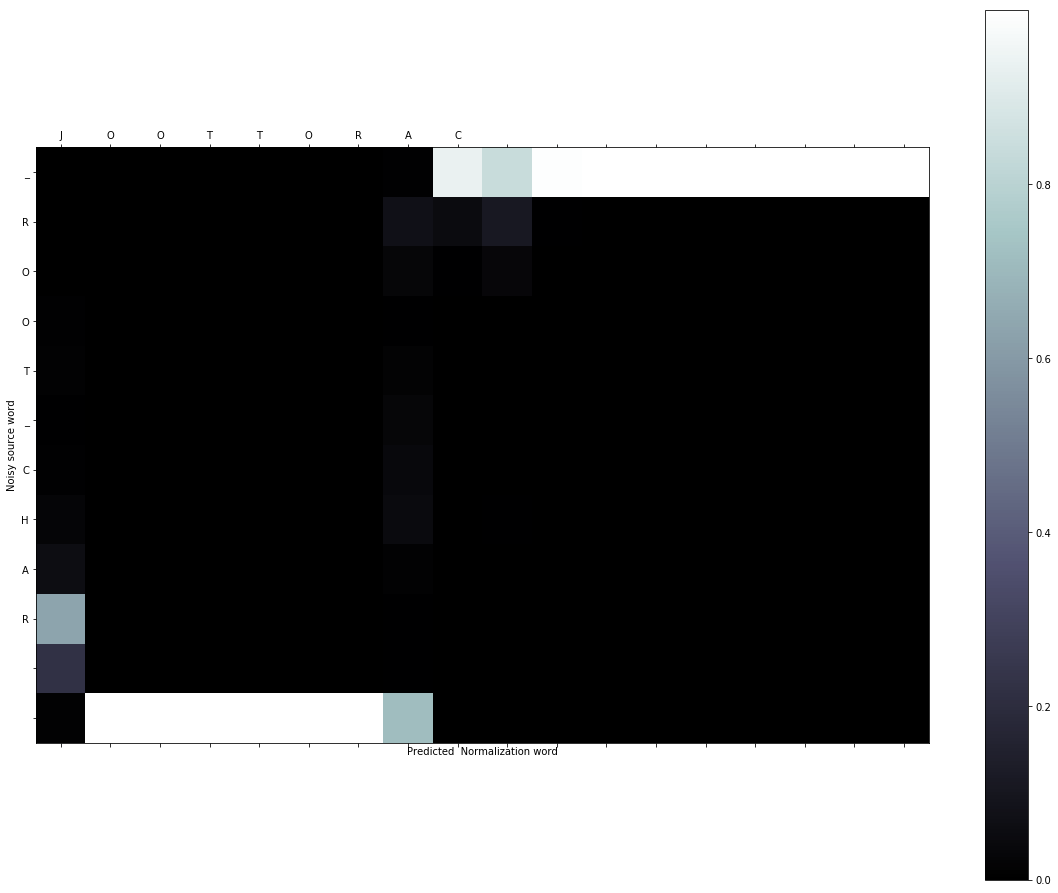

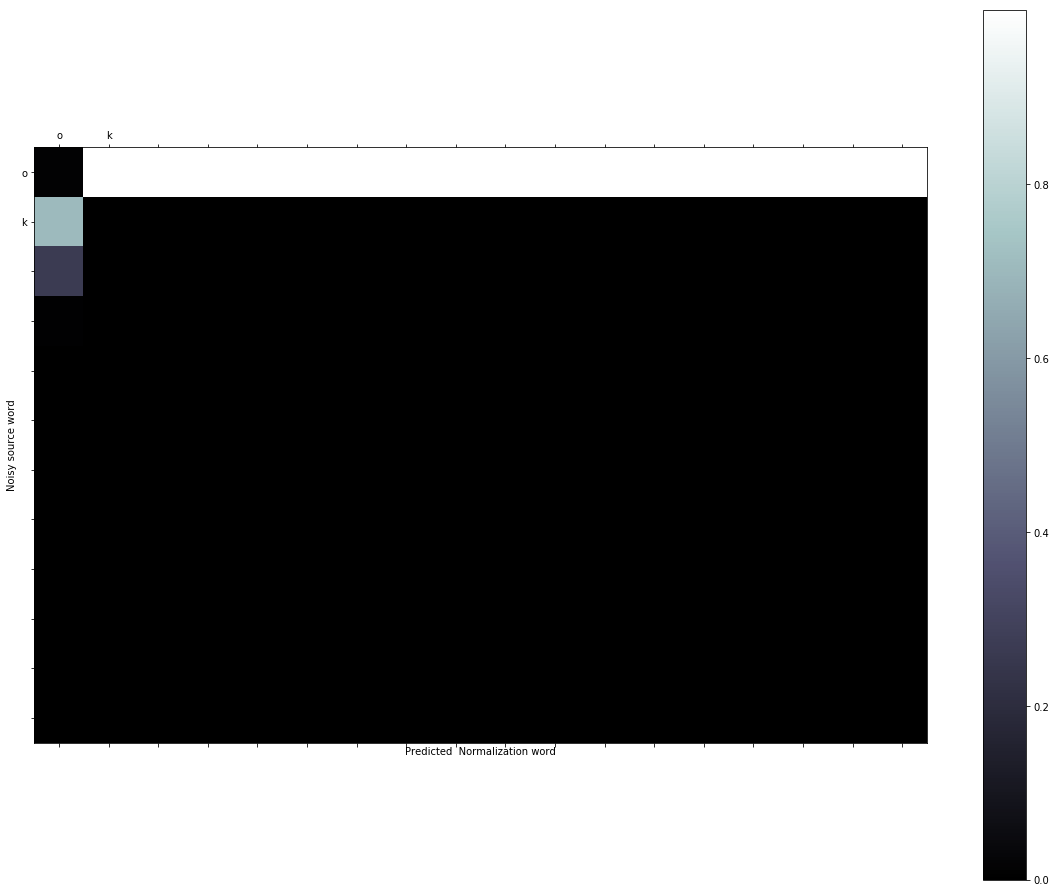

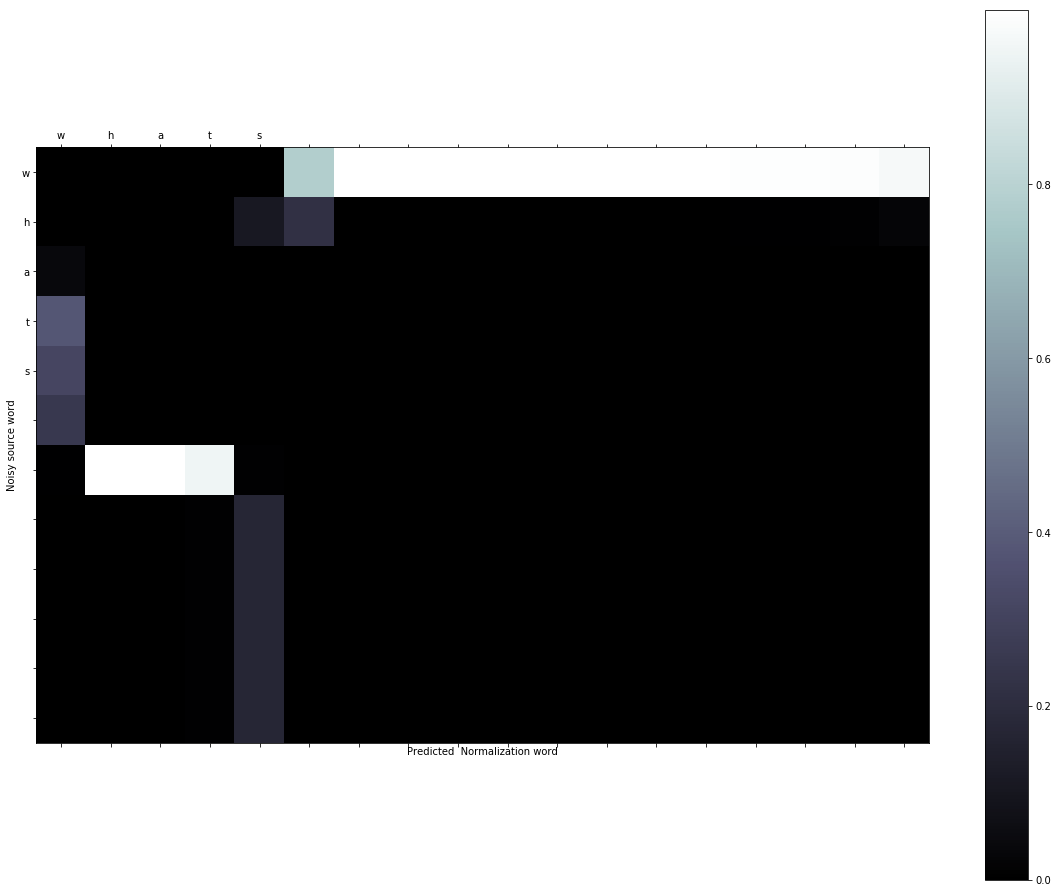

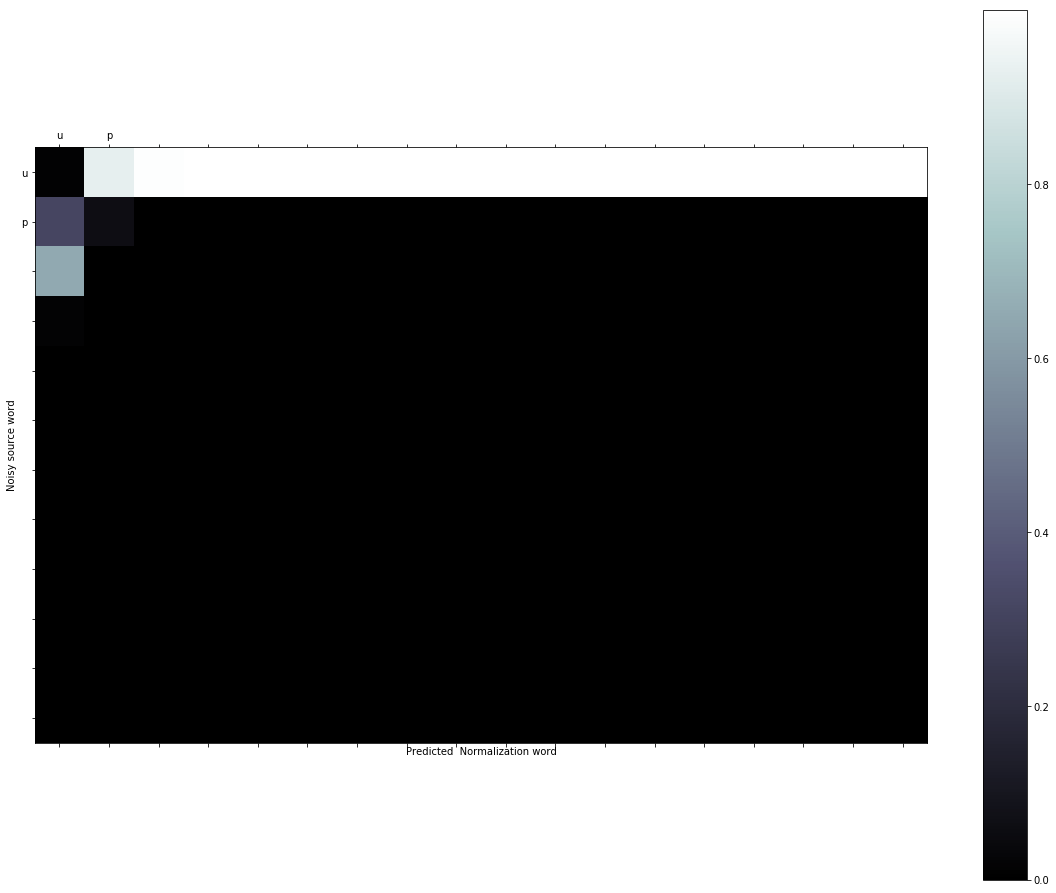

DECODED text is : ['JOOTTORAC', 'ok', 'whats', 'up'] original is ['_ROOT_CHAR', 'ok', 'whats', 'up', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    egeg
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['egeg']
Attention tensor([[[ 2.2363e-05,  1.1688e-03,  1.9834e-03,  1.0403e-02,  1.3236e-02,
           5.1369e-03,  8.6930e-03,  2.6983e-02,  6.0372e-02,  6.3392e-01,
           2.2426e-01,  1.3826e-02],
         [ 2.9608e-15,  1.1514e-13,  5.6171e-14,  1.6837e-13,  4.1957e-12,
           1.3959e-11,  7.2381e-11,  7.2894e-11,  5.7013e-10,  6.2863e-07,
           4.0767e-07,  1.0000e+00],
         [ 3.5369e-14,  2.0775e-11,  1.1669e-11,  2.3192e-11,  3.4141e-10,
           1.4992e-09,  6.4328e-09,  1.2550e-08,  8.1890e-08,  6.2326e-05,
           1.3008e-05,  9.9992e-01],
         [ 7.5038e-13,  6.9517e-10,  6.6726e-10,  5.7042e-10,  1.17

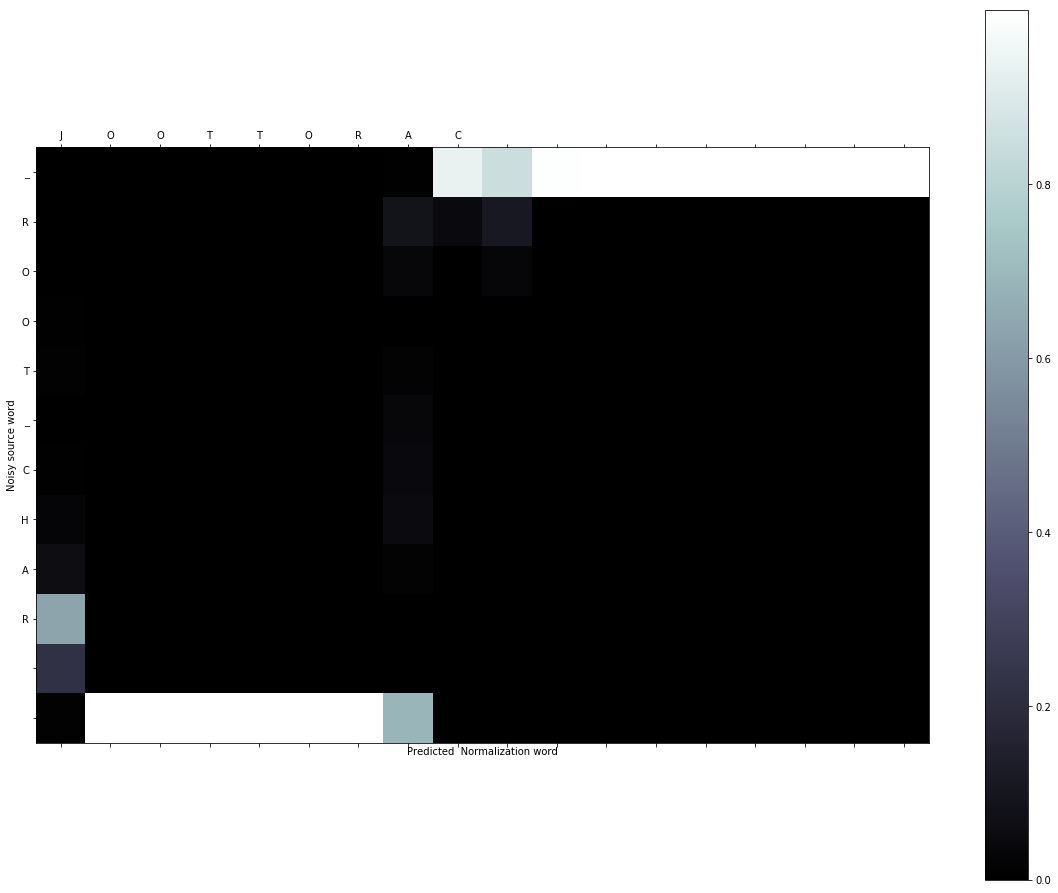

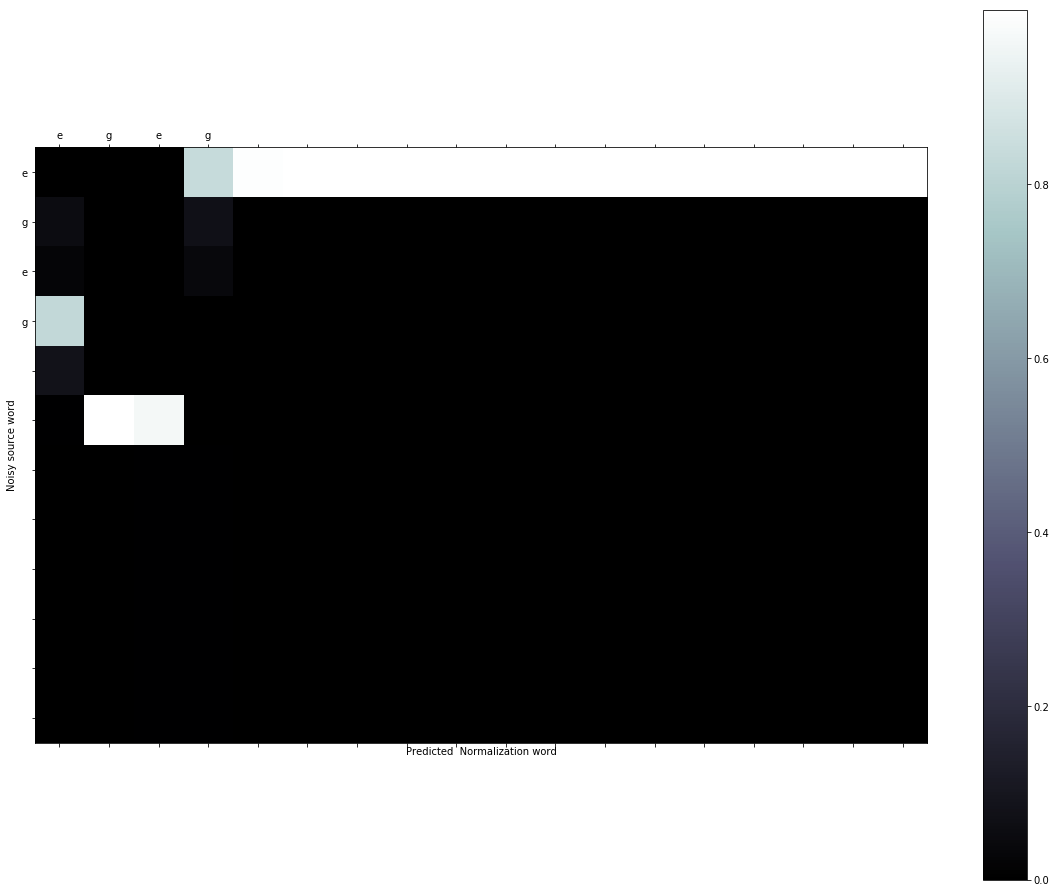

DECODED text is : ['JOOTTORAC', 'egeg'] original is ['_ROOT_CHAR', 'egeg', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    18-55mm
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['18-55mm']
Attention tensor([[[ 2.2363e-05,  1.1688e-03,  1.9834e-03,  1.0403e-02,  1.3236e-02,
           5.1369e-03,  8.6930e-03,  2.6983e-02,  6.0372e-02,  6.3392e-01,
           2.2426e-01,  1.3826e-02],
         [ 2.2140e-15,  9.5350e-14,  4.7394e-14,  1.5068e-13,  3.8080e-12,
           1.1915e-11,  6.3786e-11,  6.1504e-11,  5.0125e-10,  6.2120e-07,
           3.8639e-07,  1.0000e+00],
         [ 2.2563e-14,  1.4756e-11,  8.3953e-12,  1.7095e-11,  2.5298e-10,
           1.0796e-09,  4.7321e-09,  9.1639e-09,  6.2601e-08,  5.5511e-05,
           1.1454e-05,  9.9993e-01],
         [ 4.7659e-13,  4.8099e-10,  4.7012e-10,  4.1612e-10,  8.6137e-09,
           3

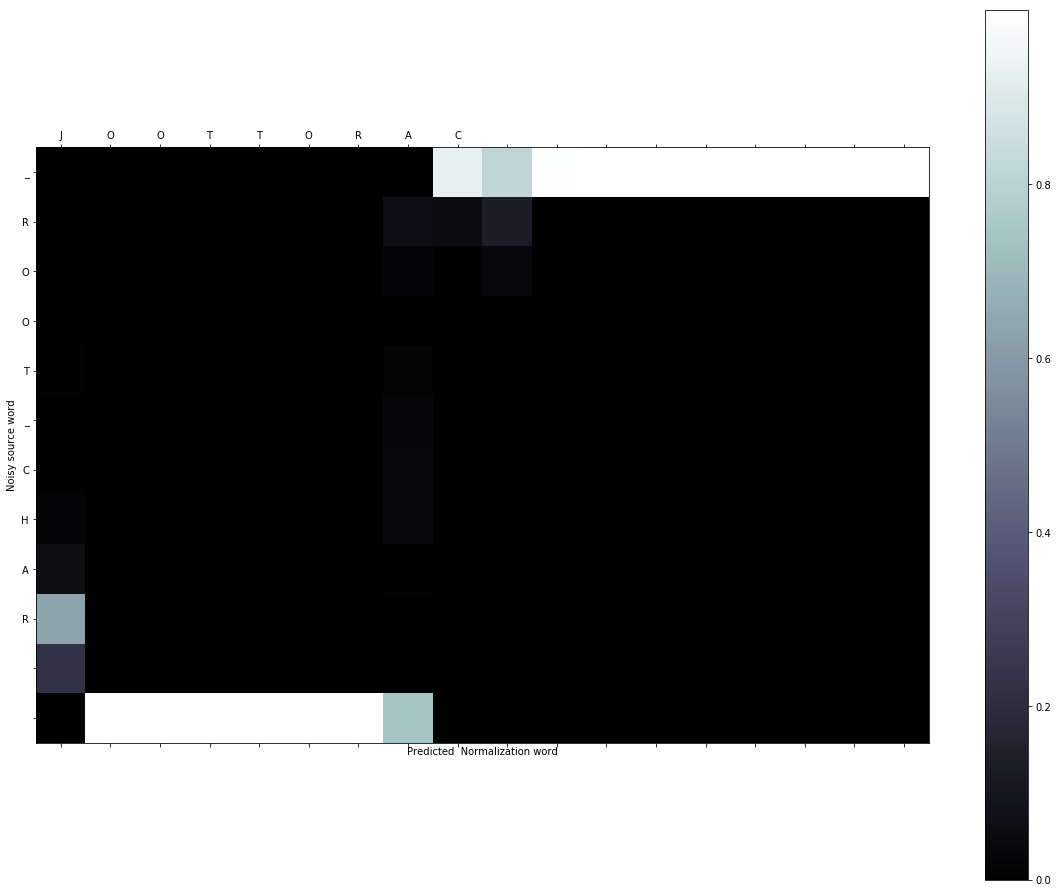

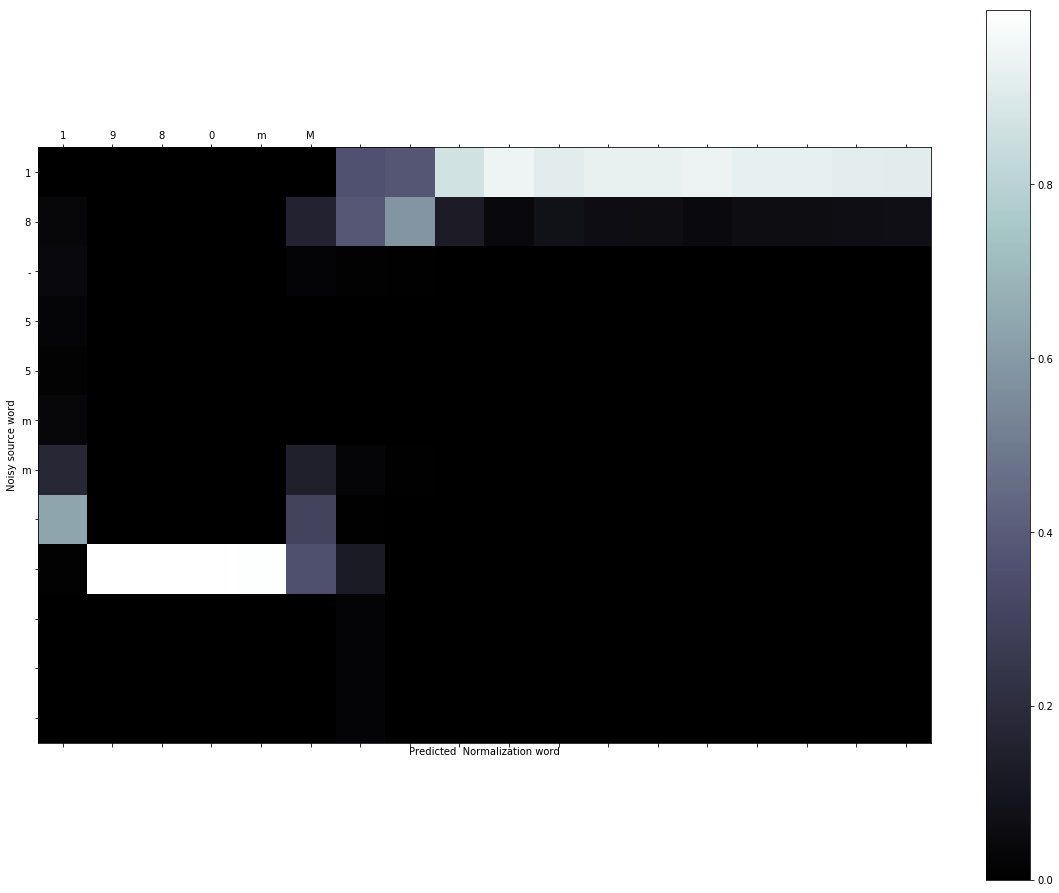

DECODED text is : ['JOOTTORAC', '1980mM'] original is ['_ROOT_CHAR', '18-55mm', '_END'] and None seen as word embed 
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    Denzel
Please type what you want to normalize word by word and finishes by 'stop' ? to end type : 'END'    stop
sent ['Denzel']
Attention tensor([[[ 2.2363e-05,  1.1688e-03,  1.9834e-03,  1.0403e-02,  1.3236e-02,
           5.1369e-03,  8.6930e-03,  2.6983e-02,  6.0372e-02,  6.3392e-01,
           2.2426e-01,  1.3826e-02],
         [ 2.6232e-15,  9.4148e-14,  4.5509e-14,  1.3446e-13,  3.4195e-12,
           1.1645e-11,  6.0069e-11,  5.7254e-11,  4.4904e-10,  5.2632e-07,
           3.4564e-07,  1.0000e+00],
         [ 2.5001e-14,  1.4283e-11,  7.9259e-12,  1.5500e-11,  2.3419e-10,
           1.0536e-09,  4.5614e-09,  8.7224e-09,  5.8292e-08,  4.9292e-05,
           1.0531e-05,  9.9994e-01],
         [ 5.4785e-13,  4.8206e-10,  4.4972e-10,  3.6934e-10,  7.7926e-09,
         

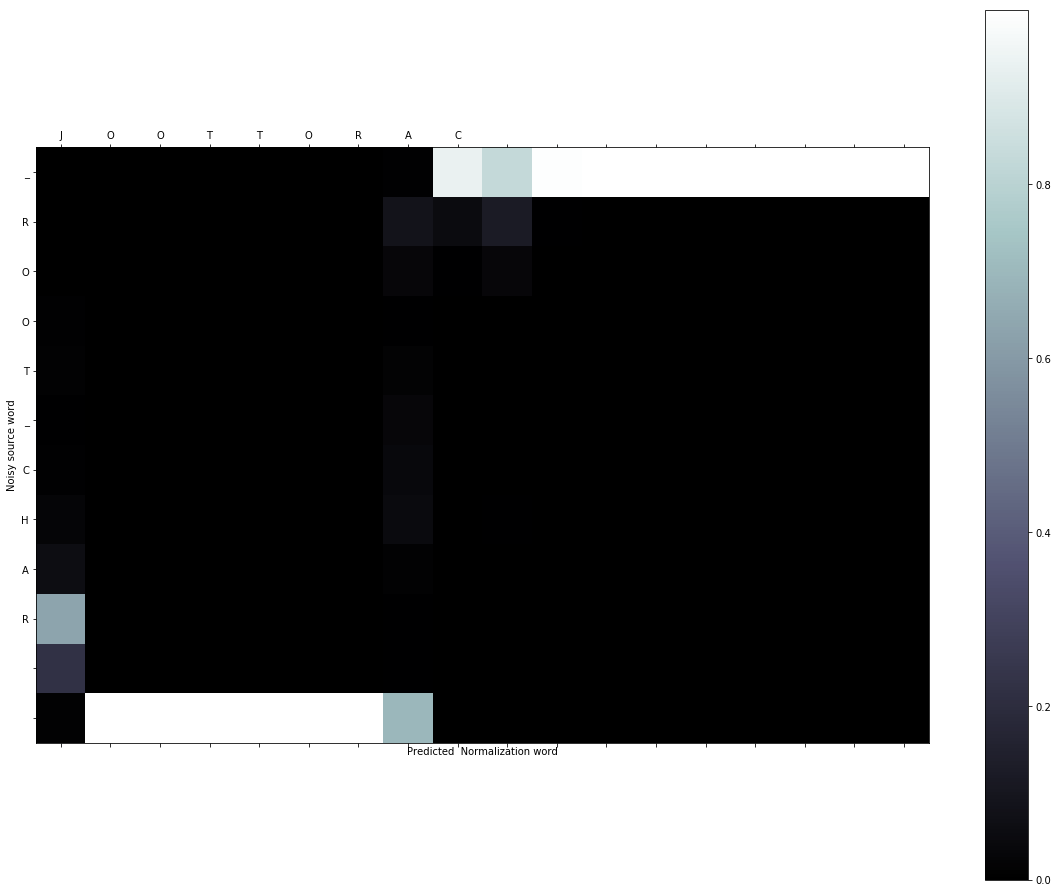

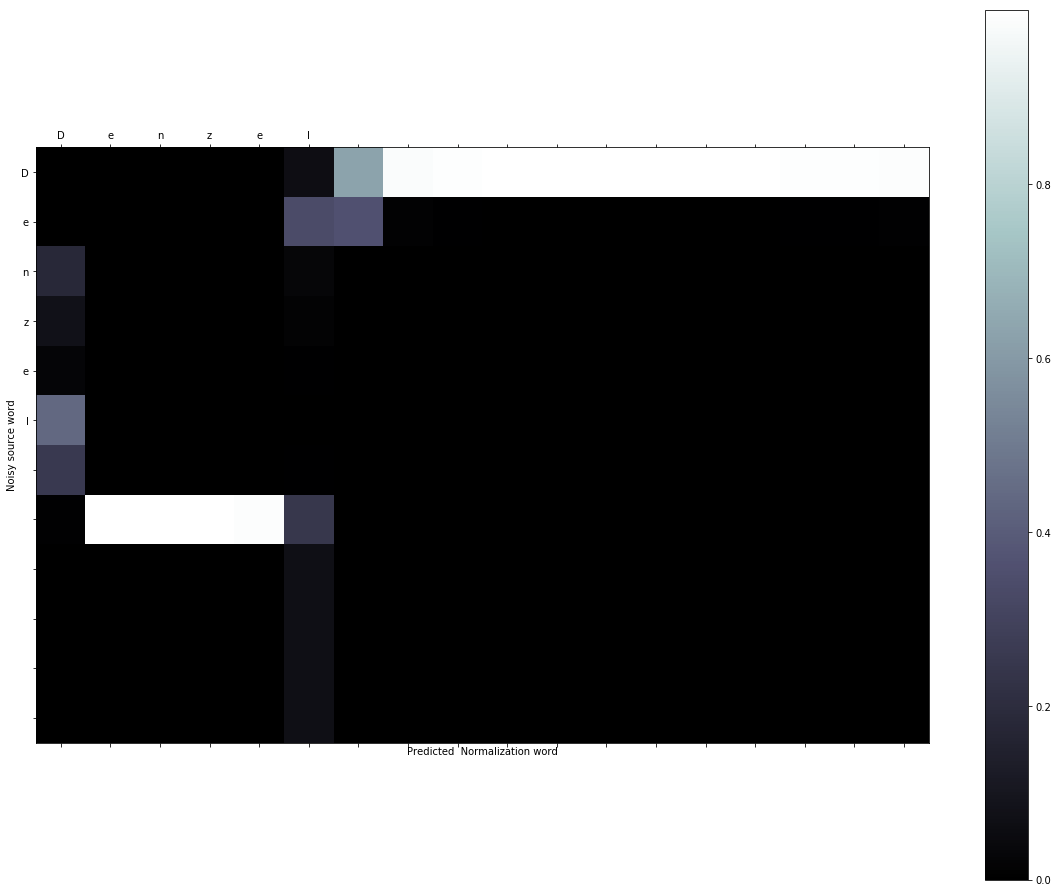

DECODED text is : ['JOOTTORAC', 'Denzel'] original is ['_ROOT_CHAR', 'Denzel', '_END'] and None seen as word embed 


In [ ]:
for folder_name in list_:
    assert len(list_)>0, "list empty"
    model_full_name = folder_name[:-7]
    print("\n\n--------------------------------Interatcing with new model--------------------------------\n", model_full_name,"\n\n")
    dic_path = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder", "dictionaries")
    model_dir = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder")
    interact(dic_path=dic_path, dir_model=model_dir, model_full_name=model_full_name, debug=False, 
             show_attention=False,verbose=0,
             save_attention=False)
    #break

## Comments
- on model 97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e with auxilliary task no attention quite small model
    - interesting case : 
        - my normalized to tomorrow : probably bcause of 2mor --> tommorow 
    - very lame at decoding very short word ? 
- 97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1
    - attention is not static --> but no clear trend
    - interetsintgly with same model but only using sent context : the attention focus on last word all the time "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92" 
    
- "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
    - the best model you played with so far
    - classification does not agree with seq predictiion : most of the classification is NORMED while it performs some change

In [ ]:
!open

In [ ]:
"./dat